## Introducing JuliaLang

While Python is the standard language in Google Colab., JuliaLang, which is faster and as flexible as Python, will be a primary choice in the exercise of the quantum many-body problems.

First of all, please execute the instruction of the following cell.

Type shitf+enter or use the button on the right-hand side of the cell.

The procedure to run JuliaLang on Google Colab., which was originally introduced by a developer in Google, is explained in the following articles written in Japanese:

https://qiita.com/ueuema/items/ca1b326f5df10a4203bd

https://qiita.com/cometscome_phys/items/1ba6ec181bb0fe1b35d5

In [ ]:
!curl -sSL "https://julialang-s3.julialang.org/bin/linux/x64/1.7/julia-1.7.2-linux-x86_64.tar.gz" -o julia.tar.gz
!tar -xzf julia.tar.gz -C /usr --strip-components 1
!rm -rf julia.tar.gz*
!julia -e 'using Pkg; Pkg.add("IJulia")'

## Settings of runtime

After executing the instructions in the above cell,

please check whether the runtime is "julia-1.7" or not. 

From the "runtime" in the menue, you can change the runtime.

When the runtime is "julia-1.7," please preserve the settings.

## Examining whether JuliaLang is introduced successfully or not

Please execute the instruction in the following cell.

**If you find the version information of JuliaLang, you introduced Julia successfully**

In [ ]:
versioninfo()

Julia Version 1.7.2
Commit bf53498635 (2022-02-06 15:21 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, haswell)


# An example of numerical simulations by JuliaLang

Then, let's run an example of a Julia code.

# Hubbard model

2nd quantization for electrons:

$|\Phi\rangle = \sum_{\nu_{j} = 0,1}C_{\nu_0 \nu_1 \nu_2 \nu_3 \cdots
\nu_{2\ell}\nu_{2\ell+1}
\cdots
\nu_{2L-2}\nu_{2L-1}
}(\hat{c}^{\dagger}_{0\uparrow})^{\nu_0}
(\hat{c}^{\dagger}_{0\downarrow})^{\nu_1}
(\hat{c}^{\dagger}_{1\uparrow})^{\nu_2}
(\hat{c}^{\dagger}_{1\downarrow})^{\nu_3}
\cdots
(\hat{c}^{\dagger}_{\ell \uparrow})^{\nu_{2\ell }}
(\hat{c}^{\dagger}_{\ell \downarrow})^{\nu_{2\ell +1}}
\cdots
(\hat{c}^{\dagger}_{L-1 \uparrow})^{\nu_{2L -2 }}
(\hat{c}^{\dagger}_{L-1 \downarrow})^{\nu_{2L -1}}
|0\rangle$

$\rightarrow$

$v\left[1+\sum_{j=0}^{2L-1} \nu_j \cdot 2^j \right] =  C_{\nu_0 \nu_1 \nu_2 \nu_3 \cdots
\nu_{2\ell}\nu_{2\ell+1}\cdots
\nu_{2L-2}\nu_{2L-1}}$

In [ ]:
module Hubbard1D
#
  mutable struct Param
    t::Float64
    U::Float64
    L::Int64
    Param() = new()
  end
#
  function initialize(param::Param, t, U, L)
    param.t = t
    param.U = U
    param.L = L
  end
#
function parity(m)
    m ⊻= m>>1 # XOR
    m ⊻= m>>2 # XOR
    m = (m&Int64(0x1111111111111111) ) *  Int64(0x1111111111111111)
    return (m>>60)&1
end
#
function Cop(ell,i,c0)
  icomb = 2^ell
  if parity(i&icomb) == 1
    return i,0.0
  else
    j = i⊻icomb
    sgn = 1.0 - 2.0*parity(i&(icomb-1))
    return j, c0 * sgn
  end
end
#
function Aop(ell,i,c0)
  icomb = 2^ell
  if parity(i&icomb) == 0
    return i,0.0
  else
    j = i⊻icomb
    sgn = 1.0 - 2.0*parity(i&(icomb-1))
    return j, c0 * sgn
  end
end
# Hubbard hamiltonian
  function multiply(param::Param,v0,v1)
    for k = 1:2^(2*param.L)
        c0 = v0[k]
        i = k - 1
        # define 1D Hubbard
        for ell = 0:param.L-1
          j1, c1 = Aop(2*ell,i,c0)
          j2, c2 = Cop(2*mod(ell+1,param.L),j1,c1)
          v1[j2+1] -= param.t * c2
          j1, c1 = Aop(2*ell,i,c0)
          j2, c2 = Cop(2*mod(ell-1,param.L),j1,c1)
          v1[j2+1] -= param.t * c2
          j1, c1 = Aop(2*ell+1,i,c0)
          j2, c2 = Cop(2*mod(ell+1,param.L)+1,j1,c1)
          v1[j2+1] -= param.t * c2
          j1, c1 = Aop(2*ell+1,i,c0)
          j2, c2 = Cop(2*mod(ell-1,param.L)+1,j1,c1)
          v1[j2+1] -= param.t * c2
          j1, c1 = Aop(2*ell,i,c0)
          j2, c2 = Cop(2*ell,j1,c1)
          j1, c1 = Aop(2*ell+1,j2,c2)
          j2, c2 = Cop(2*ell+1,j1,c1)
          v1[j2+1] += param.U * c2
        end
    end
    return 0
  end
#
  function countbit(i,length)
    j = 0
    for k = 0:length-1
      icomb = 2^k
      j += parity(i&icomb)
    end
    return j
  end
#
end

Main.Hubbard1D

## Exercise

In [ ]:
using .Hubbard1D

### parity: whether the number of electrons is even (0) or odd (1).

In [ ]:
Hubbard1D.parity(Int(0b1011)) # 0th up, 0th down, 1th down

1

### creation and annihilation operators

In [ ]:
ell = 4
icomb = 2^ell
string(icomb, base=2)
i = Int(0b1101) # 0th up, 1th up, 1th down 
println("i=",i) # digit for "1101"
j,c1= Hubbard1D.Cop(1,i,1.0) # generate an down-spin electron at 0th site 
println(string(j, base=2),"  ",c1)
j,c1= Hubbard1D.Aop(2,i,1.0) # annihilate an up-spin electron at 1st site
string(j, base=2)

i=13
1111  -1.0


"1001"

### Two site Hubbard model

In [ ]:
t = 0.5 # be careful about the boundary condition
U = 8.0
L = 2
nelec = 2
param = Hubbard1D.Param()
Hubbard1D.initialize(param,t,U,L)
v0 = zeros(Complex{Float64}, 2^(2*param.L))
#
Ndim = 0
println("basis")
for k = 1:2^(2*param.L)
  if Hubbard1D.countbit(k-1,2*param.L) == nelec
    global Ndim += 1
    println(Ndim,"  ",string(k-1,base=2))
  end
end
# construct the hamiltonian matrix
matrixH = zeros(Complex{Float64}, Ndim, Ndim)
jcount = 0
for k = 1:2^(2*param.L)
  if Hubbard1D.countbit(k-1,2*param.L) == nelec
    jcount +=1
    v0[k] = 1.0
    v1 = zeros(Complex{Float64}, 2^(2*param.L))
    Hubbard1D.multiply(param,v0,v1)
    v0[k] = 0.0
    icount = 0
    for m = 1:2^(2*param.L)
      if Hubbard1D.countbit(m-1,2*param.L) == nelec
        icount += 1
        matrixH[icount,jcount] += v1[m]
      end
    end
  end
end

basis
1  11
2  101
3  110
4  1001
5  1010
6  1100


Please confirm the following calculation:

$\langle0|
(\hat{c}^{\ }_{L-1 \downarrow})^{\nu'_{2L -1}}
(\hat{c}^{\ }_{L-1 \uparrow})^{\nu'_{2L -2 }}
\cdots
(\hat{c}^{\ }_{1\downarrow})^{\nu'_3}
(\hat{c}^{\ }_{1\uparrow})^{\nu'_2}
(\hat{c}^{\ }_{0\downarrow})^{\nu'_1}
(\hat{c}^{\ }_{0\uparrow})^{\nu'_0}
$

$\times
(\hat{c}^{\dagger}_{0\uparrow})^{\nu_0}
(\hat{c}^{\dagger}_{0\downarrow})^{\nu_1}
(\hat{c}^{\dagger}_{1\uparrow})^{\nu_2}
(\hat{c}^{\dagger}_{1\downarrow})^{\nu_3}
\cdots
(\hat{c}^{\dagger}_{L-1 \uparrow})^{\nu_{2L -2 }}
(\hat{c}^{\dagger}_{L-1 \downarrow})^{\nu_{2L -1}}
|0\rangle$

$= \delta_{\nu_0,\nu'_0}
\delta_{\nu_1,\nu'_1}
\delta_{\nu_2,\nu'_2}
\delta_{\nu_3,\nu'_3}
\cdots
\delta_{\nu_{2L-2},\nu'_{2L-2}}
\delta_{\nu_{2L-1},\nu'_{2L-1}}$

diagonalize the hamiltonian matrix

In [ ]:
using LinearAlgebra
eig = eigvals(matrixH)
wf = eigvecs(matrixH)
println("E_0=",eig[1])
wf[:,1]

E_0=-0.4721359549995794


6-element Vector{ComplexF64}:
 0.16245984811645325 + 0.0im
                 0.0 + 0.0im
 -0.6881909602355867 + 0.0im
  0.6881909602355867 + 0.0im
                 0.0 + 0.0im
 0.16245984811645298 - 0.0im

# Liquid helium 4

First, import some packages.
It will take several minutes.

In [ ]:
import Pkg; Pkg.add("Plots")
using Plots
using Random

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed x265_jll ───────────────────── v3.5.0+0
   Installed JpegTurbo_jll ──────────────── v2.1.2+0
   Installed GR_jll ─────────────────────── v0.64.4+0
   Installed Opus_jll ───────────────────── v1.3.2+0
   Installed LERC_jll ───────────────────── v3.0.0+1
   Installed libfdk_aac_jll ─────────────── v2.0.2+0
   Installed Libmount_jll ───────────────── v2.35.0+0
   Installed EarCut_jll ─────────────────── v2.2.3+0
   Installed Xorg_xkbcomp_jll ───────────── v1.4.2+4
   Installed Measures ───────────────────── v0.3.1
   Installed RelocatableFolders ─────────── v0.1.3
   Installed StaticArrays ───────────────── v1.4.7
   Installed Xorg_xcb_util_image_jll ────── v0.4.0+1
   Installed Xorg_xcb_util_wm_jll ───────── v0.4.1+1
   Installed Grisu ──────────────────────── v1.0.2
   Installed Formatting ─────────────────── v0.4.2
   Installed Contour ────────────────────── v0.5.7
   Installed Xor

module for liquid helium 4

In [ ]:
module Helium4

# physical constant
    hbar = 1.054571e-34 # kg m^2 / s
    kB = 1.380649e-23 # J / K
  # mass of helium 4 atom
    massHe4 = 4.00260325415 * 1.0e-3 / 6.022140e+23 # kg
    mass = kB * massHe4 * 1.0e-20 / hbar^2 # K^-1 angstrom^-2
  # parameters for Lenard-Jones 6-12 potential
    epsLJ = 1.41102e-22 / kB # K
    sigmaLJ = 2.556 # angstrom

# parameters and valuables  
    mutable struct Param
        a1::Float64
        a2::Float64
        L::Float64
        N::Int
        rcut::Float64
        config::Array{Float64,2} # (3,N)
        dist::Array{Float64,2} #  (N,N)
        Param() = new()
    end

# initialization
    function initialize(param::Param, a1, a2, L, N)
        param.a1 = a1
        param.a2 = a2
        param.L = L
        param.N = N
        param.rcut = 0.5*a1
        param.config = zeros(Float64,3,N) # column-major
        param.dist = zeros(Float64,N,N) # column-major
        return 0 
    end

    function initialize_config(param::Param)
        for j in 1:param.N
            for i in 1:3
                param.config[i,j] = param.L * rand(Float64)
            end
        end
        for iupdate in 1:param.N
            update_dist(param, iupdate)
        end
    end

# update the configuration of the atoms
    function update_config(param::Param, iupdate)
        d = 0.05*param.L
        for i in 1:3
            param.config[i,iupdate] += 2.0*d*(rand(Float64)-0.5)
            param.config[i,iupdate] = mod(param.config[i,iupdate], param.L)
        end
    end

    function update_dist(param::Param, iupdate)
        for i in 1:param.N
            tmp_dist = dist_periodic(param,param.config[:,i],param.config[:,iupdate])
            if tmp_dist > param.rcut
                param.dist[i,iupdate] = tmp_dist
                param.dist[iupdate,i] = tmp_dist
            else
                param.dist[i,iupdate] = param.rcut
                param.dist[iupdate,i] = param.rcut
            end
        end
    end

    function dist_periodic(param::Param, r1, r2)
        dist_old = sqrt(3.0)*param.L
        for iz in -1:1
            for iy in -1:1
                for ix in -1:1
                    tmp_dist = 0.0
                    tmp_dist += (param.L*ix + r1[1] - r2[1])^2
                    tmp_dist += (param.L*iy + r1[2] - r2[2])^2
                    tmp_dist += (param.L*iz + r1[3] - r2[3])^2
                    tmp_dist = sqrt(tmp_dist)
                    if tmp_dist < dist_old
                        dist_old = tmp_dist
                    end
                end
            end
        end
        return dist_old
    end

# Jastrow factor
    function func_u(param::Param, r::Float64)
        uofr = 0.0
        if r > param.rcut
            uofr = (param.a1/r)^param.a2
        else
            uofr = (param.a1/param.rcut)^param.a2
        end
        return uofr
    end

# radial two-point distribution function
    function accum_Nrdr(param::Param, Ndr, Nrdr)
        rmax = 0.5*param.L
        dr = rmax/Ndr
        for m in 1:Ndr
            r = rmax*(m-0.5)/Ndr
            for j in 1:(param.N-1)
                for i in (j+1):param.N
                    if (param.dist[i,j] >= r - 0.5*dr) && (param.dist[i,j] < r + 0.5*dr)
                        Nrdr[m] += 1.0
                    end
                end
            end
        end
    end
    
    function calc_gofr(param::Param, Nsample, Ndr, Nrdr, gofr, vecr)
        Ω = param.L^3
        ρ = param.N*1.0 / Ω
        rmax = 0.5*param.L
        dr = rmax/Ndr
        for m in 1:Ndr
            r = rmax*(m-0.5)/Ndr
            vecr[m] = r
            gofr[m] = Nrdr[m]/(2.0*Nsample*π*(ρ^2)*Ω*(r^2)*dr)
        end
    end

end

Main.Helium4

set parameters

In [ ]:
using .Helium4

a1 = 2.6 # variational parameter
a2 = 5.0 # variational parameter
L = 11.2　# linear length of the cubic cell (periodic boundary condition) (ang)
N = 32 # number of atoms in the cubic cell

param = Helium4.Param()
Helium4.initialize(param, a1, a2, L, N)
Helium4.initialize_config(param)

In [ ]:
Nwup = 3200 # number of warming up steps
Nsample = 12800 # number of MC samples
Random.seed!(10) # set a seed for the psuedo random number generator
# preparation for the radial two-point distribution function
Ndr = 64
Nrdr = zeros(Float64, Ndr)
gofr = zeros(Float64, Ndr)
vecr = zeros(Float64, Ndr)

64-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

## warming up

In [ ]:
# warming up
config_old = zeros(Float64, 3, param.N)
dist_old = zeros(Float64, param.N, param.N)
for i in 1:Nwup
    for j in 1:param.N
        config_old .= param.config
        dist_old .= param.dist
        iupdate = Int(floor(rand(Float64)*param.N)) + 1
        if iupdate > param.N
            println("error!", iupdate)
        end
        Helium4.update_config(param,iupdate)        
        Helium4.update_dist(param,iupdate)
        lnPNt = 0.0
        lnPNi = 0.0
        for m in 1:param.N
            if m ≠ iupdate
                lnPNt -= 2.0*Helium4.func_u(param,param.dist[m,iupdate])
                lnPNi -= 2.0*Helium4.func_u(param,dist_old[m,iupdate])
                if (param.dist[m,iupdate]- dist_old[m,iupdate]) == 0.0
                   println("dist is not")
                end
            end
        end
        ratio = exp(lnPNt - lnPNi)
        if ratio <= rand(Float64)
            param.config[:,:] = config_old[:,:]
            param.dist[:,:] = dist_old[:,:]
        end
    end
    if i % 100 == 0
        println("Wup",i," ",param.config[1,1])
    end
end

dist is not
dist is not
dist is not
dist is not
dist is not
dist is not
Wup100 3.3103010346579422
Wup200 0.2085332322253463
Wup300 0.9337161800875188
Wup400 0.5632339919823744
Wup500 1.1724128872840422
Wup600 2.0898914215816236
Wup700 1.4941968865162272
Wup800 3.7666532699601474
Wup900 4.585637243028225
Wup1000 0.30284162562002864
Wup1100 10.673374625615788
Wup1200 1.9334754853178024
Wup1300 1.1554503270095642
Wup1400 0.011417523630413484
Wup1500 3.7557554701572617
Wup1600 1.6677656258638847
Wup1700 7.211623355192946
Wup1800 9.163708794130887
Wup1900 6.071471624360425
Wup2000 0.012779359260538215
Wup2100 0.07412402676577547
Wup2200 0.06557794025864361
Wup2300 1.440743803743968
Wup2400 4.030913511575854
Wup2500 0.9164359211088556
Wup2600 1.860421056916809
Wup2700 1.8080002619805557
Wup2800 4.014280974545583
Wup2900 6.951802881748961
Wup3000 8.282979052658883
Wup3100 8.796926548090868
Wup3200 9.069115907164477


## MC sampling

In [ ]:
for i in 1:Nsample
    for j in 1:param.N
        config_old .= param.config
        dist_old .= param.dist
        iupdate = Int(floor(rand(Float64)*param.N)) + 1
        Helium4.update_config(param,iupdate)
        Helium4.update_dist(param,iupdate)
        lnPNt = 0.0
        lnPNi = 0.0
        for m in 1:param.N
            if m ≠ iupdate
                lnPNt -= 2.0*Helium4.func_u(param,param.dist[m,iupdate])
                lnPNi -= 2.0*Helium4.func_u(param,dist_old[m,iupdate])
            end
        end
        ratio = exp(lnPNt - lnPNi)
        if ratio <= rand(Float64)
            param.config[:,:] = config_old[:,:]
            param.dist[:,:] = dist_old[:,:]
        end
    end
    if i % 100 == 0
        println("MCstep",i," ",param.config[1,1])
    end
    Helium4.accum_Nrdr(param,Ndr,Nrdr)
end
Helium4.calc_gofr(param,Nsample,Ndr,Nrdr,gofr,vecr)

MCstep100 6.924185587319796
MCstep200 5.021382249228975
MCstep300 4.945676356754449
MCstep400 3.264026314613644
MCstep500 5.36361492085458
MCstep600 6.012653024718381
MCstep700 8.042227845883021
MCstep800 10.484254271111036
MCstep900 10.017785039694141
MCstep1000 9.838649237436252
MCstep1100 6.665436752742816
MCstep1200 9.400658055629728
MCstep1300 6.520063945734464
MCstep1400 4.801839642780417
MCstep1500 3.5691247219071283
MCstep1600 0.7493448202422277
MCstep1700 1.5233022846329043
MCstep1800 3.275686495230141
MCstep1900 2.72937419735678
MCstep2000 2.9575748737920904
MCstep2100 3.893758547901052
MCstep2200 6.066842827773705
MCstep2300 4.273885088978189
MCstep2400 3.310540999760776
MCstep2500 4.6896374689287095
MCstep2600 5.50488384684695
MCstep2700 3.8259830442875695
MCstep2800 3.7312913849737948
MCstep2900 2.8669116852613277
MCstep3000 5.251062926063148
MCstep3100 3.8456941243123444
MCstep3200 1.920367528457688
MCstep3300 4.676785106612691
MCstep3400 3.287028117942503
MCstep3500 0.59

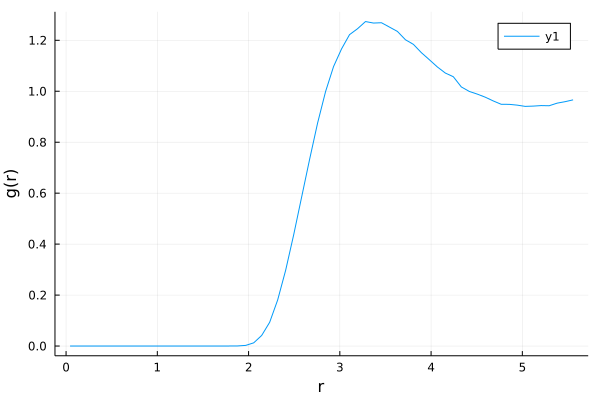

Your GR installation is incomplete. Rerunning build step for GR package.


┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1423
ERROR: LoadError: InitError: could not load library "/root/.julia/artifacts/a84cc58d5161b950f268bb562e105bbbf4d6004a/lib/libGL.so"
/root/.julia/artifacts/a84cc58d5161b950f268bb562e105bbbf4d6004a/lib/libGL.so: undefined symbol: _glapi_tls_Current
Stacktrace:
  [1] dlopen(s::String, flags::UInt32; throw_error::Bool)
    @ Base.Libc.Libdl ./libdl.jl:117
  [2] dlopen(s::String, flags::UInt32)
    @ Base.Libc.Libdl ./libdl.jl:117
  [3] macro expansion
    @ ~/.julia/packages/JLLWrappers/QpMQW/src/products/library_generators.jl:54 [inlined]
  [4] __init__()
    @ Libglvnd_jll ~/.julia/packages/Libglvnd_jll/pJrjy/src/wrappers/x86_64-linux-gnu.jl:22
  [5] _include_from_serialized(path::String, depmods::Vector{Any})
    @ Base ./loading.jl:768
  [6] _require_search_from_serialized(pkg::Base.PkgId, sourcepath::String)
    @ Base ./loading.jl:854
  [7] _require(pkg::Base.PkgId)
    @ Base ./loading.jl:1097

In [ ]:
plot(vecr,gofr,xlabel="r",ylabel="g(r)")